In [ ]:
#@title
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline


from torchvision import transforms
import os
from natsort import natsorted
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import os
import zipfile 
import gdown
import torch
from natsort import natsorted
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision import datasets, transforms

In [ ]:
#@title
class ConvNet(nn.Module):
  
    def __init__(self, image_size=128, n_hidden_layers = 2, n_hidden_channels=16,
                 dim_out = 100,
                 kernel_size = 3, stride = 2):
        super(ConvNet, self).__init__()
        
        self.cnn = nn.Sequential(nn.Conv2d(3, n_hidden_channels, kernel_size=kernel_size, stride=stride),
                                   nn.BatchNorm2d(n_hidden_channels),
                                   nn.LeakyReLU())
        for _ in range(n_hidden_layers-1):
          self.cnn = nn.Sequential(self.cnn,
                                   nn.Conv2d(n_hidden_channels, n_hidden_channels,
                                             kernel_size=kernel_size, stride=stride),
                                   nn.BatchNorm2d(n_hidden_channels),
                                   nn.LeakyReLU())
        
        def conv2d_size_out(size, kernel_size = 3, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        sf = image_size
        for _ in range(n_hidden_layers):
          sf = conv2d_size_out(sf)
        linear_input_size = sf**2 * n_hidden_channels
        self.head = nn.Linear(linear_input_size, dim_out)
            
    def forward(self, x):

        out = self.cnn(x)
        out = out.view(out.size(0), -1)
        out = self.head(out)
        return out

class DeConvNet(nn.Module):
  
    def __init__(self, latent_dim=100, image_size=128, n_hidden_layers = 2, n_hidden_channels=16,
                 kernel_size = 3, stride = 2):
        super(DeConvNet, self).__init__()
        
        self.n_hidden_channels = n_hidden_channels

        self.cnn = nn.Sequential()
        for _ in range(n_hidden_layers-1):
          self.cnn = nn.Sequential(self.cnn,
                                   nn.ConvTranspose2d(n_hidden_channels, n_hidden_channels,
                                             kernel_size=kernel_size, stride=stride),
                                   nn.BatchNorm2d(n_hidden_channels),
                                   nn.LeakyReLU())
        self.cnn = nn.Sequential(self.cnn,
                                 nn.ConvTranspose2d(n_hidden_channels, 3, kernel_size=kernel_size, stride=stride,
                                                    output_padding=1))
        
        def conv2d_size_out(size, kernel_size = 3, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1

        sf = image_size
        for _ in range(n_hidden_layers):
          sf = conv2d_size_out(sf)
        self.sf = sf

        linear_input_size = sf**2 * n_hidden_channels
        self.fc = nn.Linear(latent_dim, linear_input_size)

    def forward(self, x):

        x = self.fc(x)
        x = x.view(x.size(0), self.n_hidden_channels, self.sf, self.sf)
        out = self.cnn(x)
        return out

class MLP(nn.Module):

  def __init__(self, dims, dropout_p = 0.3):
        super(MLP, self).__init__()
        
        self.mlp = nn.Sequential()
        for i in range(len(dims) - 1):
            dim1, dim2 = dims[i], dims[i + 1]
            self.mlp = nn.Sequential(self.mlp, nn.Linear(dim1, dim2))
            if i + 2 < len(dims):
                self.mlp = nn.Sequential(self.mlp,
                                    nn.BatchNorm1d(dim2),
                                    nn.LeakyReLU(),
                                    nn.Dropout(p = dropout_p))
                
  def forward(self, x):
    out = self.mlp(x)
    return out
            


class Encoder(nn.Module):
    def __init__(self, image_size=128, latent_dim=100):
        super(Encoder, self).__init__()
        
        self.cnn = ConvNet(image_size=image_size,
                       n_hidden_layers = 2, n_hidden_channels=16,
                       dim_out = 1000,
                       kernel_size = 3, stride = 2)
        dims = [1000, 500, 500, latent_dim]
        self.mlp = MLP(dims=dims)

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size(0), -1)
        out = self.mlp(out)
        return out



class Decoder(nn.Module):
    def __init__(self, latent_dim=100, image_size=128):
      super(Decoder, self).__init__()
      dims = [latent_dim, 500, 500, 1000]
      self.mlp = MLP(dims=dims)
      self.cnn = DeConvNet(latent_dim=1000, image_size=image_size,
                             n_hidden_layers = 2, n_hidden_channels=16,
                             kernel_size = 3, stride = 2)
            
    def forward(self, x):
        x = self.mlp(x)
        x = self.cnn(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
#@title
class VariationalAutoencoder(nn.Module):
    def __init__(self, image_size=128, latent_dim=100):
        super().__init__()
        self.mean_encoder = Encoder(image_size=image_size, latent_dim=latent_dim)
        self.logvar_encoder = Encoder(image_size=image_size, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, image_size=image_size)
        self.training = True
    def forward(self, x):
        z_mean, z_logvar = self.mean_encoder(x), self.logvar_encoder(x)
        z = self.latent_sample(z_mean, z_logvar)
        x_recon = self.decoder(z)
        return z_mean, z_logvar, x_recon
    
    def latent_sample(self, mu, logvar):

        if self.training:
            # the reparameterization trick
            std = (logvar * 0.5).exp()
            return torch.distributions.Normal(loc=mu, scale=std).rsample()
            # std = logvar.mul(0.5).exp_()
            # eps = torch.empty_like(std).normal_()
            # return eps.mul(std).add_(mu)
        else:
            return mu

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

img_folder = '/content/gdrive/MyDrive/img_align_celeba/'

In [156]:


image_size = 32
# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])

In [157]:
celeba_dataset = datasets.ImageFolder(img_folder, transform=transform)

(3, 32, 32)


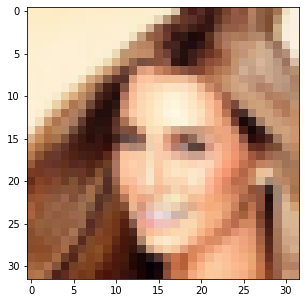

In [158]:
x = celeba_dataset[0][0].numpy()
print(x.shape)
x = x.transpose(1,2, 0)
x = (x+1)/2
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
plt.imshow(x, interpolation='nearest')

In [159]:
## Create a dataloader 
# Batch size during training
batch_size = 128
# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

In [161]:
def vae_loss(x, z_mean, z_logvar, x_recon):
    recon_loss = F.binary_cross_entropy(x_recon.view(-1, image_size**2), x.view(-1, image_size**2), reduction='sum')
    # You can look at the derivation of the KL term here https://arxiv.org/pdf/1907.08956.pdf
    kldivergence = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    
    return recon_loss + 0.01*kldivergence

In [162]:

vae = VariationalAutoencoder(image_size=image_size, latent_dim=100)
vae = vae.to(device)


optimizer = torch.optim.Adam(params=vae.parameters(), lr=1e-3, weight_decay=1e-5)
import pandas as pd

# set to training mode
vae.train()
train_loss_avg = []


In [163]:
dataset = torch.utils.data.Subset(celeba_dataset, np.random.choice(np.arange(len(celeba_dataset)), 10000))

In [164]:
# @title training utilities

import pandas as pd
import numpy as np

from typing import Callable, Optional
def make_averager() -> Callable[[Optional[float]], float]:
    """ Returns a function that maintains a running average

    :returns: running average function
    """
    count = 0
    total = 0

    def averager(new_value: Optional[float]) -> float:
        """ Running averager

        :param new_value: number to add to the running average,
                          if None returns the current average
        :returns: the current average
        """
        nonlocal count, total
        if new_value is None:
            return total / count if count else float("nan")
        count += 1
        total += new_value
        return total / count

    return averager

def save_in_dataframe(df_log, labels, mus, stddevs, epoch):
    df = pd.DataFrame()

    df['index'] = np.arange(len(mus[:,0])) * epoch 
    df['image_ind'] = np.arange(len(mus[:,0]))
    df['class'] = labels.data.numpy().astype(str)
    df['mu_x'] = mus[:,0]
    df['mu_y'] = mus[:,1]
    df['std_x'] = stddevs[:,0]
    df['std_y'] = stddevs[:,1]
    df['epoch'] = np.ones(len(mus[:,0])) * epoch
    
    df_log = pd.concat([df_log, df])

    return df_log

def run_on_testbatch(df_log, vae, epoch, x, y):
    with torch.no_grad():
        x = x.to(device)
        x, mus, stddevs = vae(x)
        x = x.to('cpu')
        mus = mus.to('cpu').data.numpy()
        stddevs = stddevs.to('cpu').mul(0.5).exp_().data.numpy()

    return save_in_dataframe(df_log, y, mus, stddevs, epoch)

def plot_loss(losses):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=list(range(len(losses))),
        y=losses,
        # name="Name of Trace 1"       # this sets its legend entry
    ))

    fig.update_layout(
        title="Train loss",
        xaxis_title="Epoch",
        yaxis_title="Loss",
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="#7f7f7f"
        )
    )
    return fig

def refresh_bar(bar, desc):
    bar.set_description(desc)
    bar.refresh()


In [165]:
# 🚥 6 minutes with default parameters 🚥

print('Training ...')
import torch.nn.functional as F
from tqdm import tqdm
num_epochs = 20
dataset = torch.utils.data.Subset(celeba_dataset, np.random.choice(np.arange(len(celeba_dataset)), 10000))

dataloader = torch.utils.data.DataLoader(dataset,
                                                batch_size=60,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=True)

tqdm_bar = tqdm(range(1, num_epochs+1), position=0, leave=True, desc="epoch [loss: ...]")
for epoch in tqdm_bar:
    train_loss_averager = make_averager()
        
    batch_bar =  tqdm(dataloader, position=0, leave=True, desc='batch', total=len(dataloader))
    for x, y in batch_bar:
        
        x = x.to(device)

        # vae reconstruction
        z_mean, z_logvar, x_recon = vae(x)
        # reconstruction error
        loss = vae_loss(x, z_mean, z_logvar, x_recon)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer 
        optimizer.step()
        
        refresh_bar(batch_bar, f"train batch [loss: {train_loss_averager(loss.item()):.3f}]")
    
    refresh_bar(tqdm_bar, f"epoch [loss: {train_loss_averager(None):.3f}]")

    train_loss_avg.append(train_loss_averager(None))

Training ...


epoch [loss: -3082707.057]: 100%|██████████| 20/20 [35:51<00:00, 107.56s/it]


In [186]:
def plot(x):
  x = x.detach().cpu().numpy()[0]
  x = x.transpose(1,2, 0)
  x = (x+1)/2
  import matplotlib.pyplot as plt
  plt.figure(figsize = (5,5))
  plt.imshow(x, interpolation='nearest')

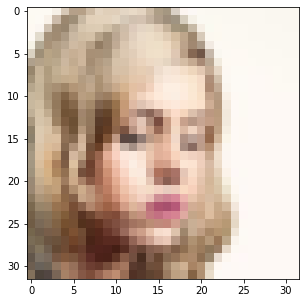

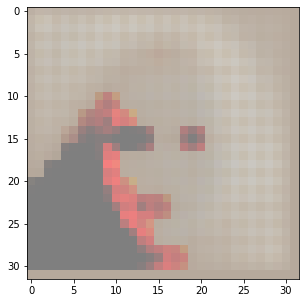

In [219]:
i = np.random.choice(len(dataset))
x = dataset[i][0]
x = x.unsqueeze(0)
x = x.to(device)
vae.eval()
z_mean, z_logvar, x_recon = vae(x)

plot(x)
plot(x_recon)

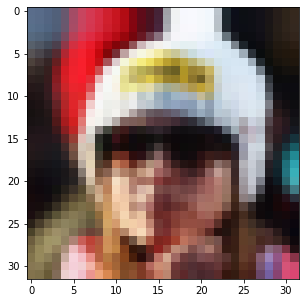

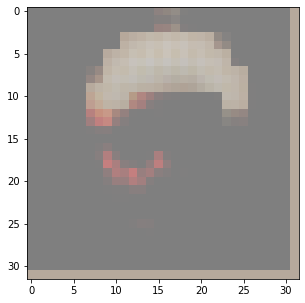

In [217]:
plot(x)
plot(x_recon)

In [238]:
test_dataset = datasets.ImageFolder('/content/gdrive/MyDrive/selfies', transform=transform)
len(test_dataset)

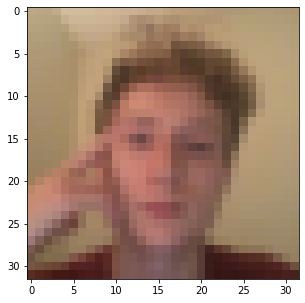

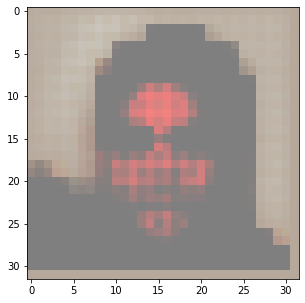

In [245]:
i = np.random.choice(len(test_dataset))
x = test_dataset[i][0]
x = x.transpose(1,2)
x = x.unsqueeze(0)

x = x.to(device)
vae.eval()
z_mean, z_logvar, x_recon = vae(x)

plot(x)
plot(x_recon)

In [248]:
torch.save(vae.state_dict(), '/content/model.pth')